# < 에러 분석 노트북 (Phase 6 준비) >

**목표:**
- OOF 예측에서 오차가 큰 케이스 분석
- 어떤 상황에서 모델이 틀리는지 파악
- 타겟팅된 개선 방향 도출

**현재 상황:**
- OOF RMSE: ~13.35m
- Public LB: 16.53m
- Stacking 완료 (Phase 5)

## 1. 환경 설정

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from pathlib import Path
from matplotlib.patches import Rectangle

# 한글 폰트 설정 (Windows)
# 1. 폰트 파일 경로 직접 지정 (윈도우 맑은 고딕 기본 경로)
font_path = 'C:/Windows/Fonts/malgun.ttf' 

# 2. 폰트 매니저에 파일 강제 등록
fm.fontManager.addfont(font_path)

# 3. 등록된 폰트의 정확한 '이름' 가져오기
font_prop = fm.FontProperties(fname=font_path)
plt.rc('font', family=font_prop.get_name())
plt.rcParams['axes.unicode_minus'] = False # 마이너스 깨짐 방지

# 스타일 설정
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# 경로 설정
DATA_DIR = Path('../data/processed')
FIG_DIR = Path('../reports/figures')
FIG_DIR.mkdir(parents=True, exist_ok=True)

print("✅ 환경 설정 완료")

✅ 환경 설정 완료


## 2. 데이터 로드

In [3]:
print("=" * 60)
print("데이터 로드")
print("=" * 60)

# OOF 예측
oof = pd.read_csv(DATA_DIR / 'oof_predictions.csv')
print(f"\n✅ OOF 예측: {oof.shape}")

# Phase 4 피처
train = pd.read_csv(DATA_DIR / 'train_final_passes_v4.csv')
print(f"✅ Phase 4 피처: {train.shape}")

# 병합 (game_episode 기준)
df = oof.merge(train, on='game_episode', how='left')
print(f"\n✅ 병합 완료: {df.shape}")
print(f"   결측치: {df.isnull().sum().sum()}개")

데이터 로드

✅ OOF 예측: (15435, 9)
✅ Phase 4 피처: (15435, 51)

✅ 병합 완료: (15435, 59)
   결측치: 0개


## 3. 에러 계산

In [31]:
print("\n" + "=" * 60)
print("에러 계산")
print("=" * 60)

# 각 모델별 에러 (유클리드 거리)
df['error_xgb'] = np.sqrt(
    (df['true_x'] - df['xgb_pred_x'])**2 + 
    (df['true_y'] - df['xgb_pred_y'])**2
)

df['error_lgb'] = np.sqrt(
    (df['true_x'] - df['lgb_pred_x'])**2 + 
    (df['true_y'] - df['lgb_pred_y'])**2
)

df['error_cat'] = np.sqrt(
    (df['true_x'] - df['cat_pred_x'])**2 + 
    (df['true_y'] - df['cat_pred_y'])**2
)

# 앙상블 예측 (균등 가중치)
df['ensemble_pred_x'] = (
    df['xgb_pred_x'] * 0.2 + 
    df['lgb_pred_x'] * 0.4 + 
    df['cat_pred_x'] * 0.4
)

df['ensemble_pred_y'] = (
    df['xgb_pred_y'] * 0.2 + 
    df['lgb_pred_y'] * 0.4 + 
    df['cat_pred_y'] * 0.4
)

df['error_ensemble'] = np.sqrt(
    (df['true_x'] - df['ensemble_pred_x'])**2 + 
    (df['true_y'] - df['ensemble_pred_y'])**2
)

print("\n✅ 에러 계산 완료")


에러 계산

✅ 에러 계산 완료


In [32]:
# 에러 통계
print("\n📊 에러 통계 (단위: m)")
print("=" * 60)

for model in ['xgb', 'lgb', 'cat', 'ensemble']:
    col = f'error_{model}'
    print(f"\n{model.upper():10s}")
    print(f"  평균:  {df[col].mean():.2f}m")
    print(f"  중앙:  {df[col].median():.2f}m")
    print(f"  표준:  {df[col].std():.2f}m")
    print(f"  최소:  {df[col].min():.2f}m")
    print(f"  최대:  {df[col].max():.2f}m")
    print(f"  90%:   {df[col].quantile(0.9):.2f}m")
    print(f"  95%:   {df[col].quantile(0.95):.2f}m")
    print(f"  99%:   {df[col].quantile(0.99):.2f}m")


📊 에러 통계 (단위: m)

XGB       
  평균:  15.71m
  중앙:  12.98m
  표준:  10.60m
  최소:  0.06m
  최대:  72.29m
  90%:   30.38m
  95%:   37.52m
  99%:   50.67m

LGB       
  평균:  15.67m
  중앙:  13.08m
  표준:  10.55m
  최소:  0.06m
  최대:  76.88m
  90%:   30.37m
  95%:   37.09m
  99%:   50.38m

CAT       
  평균:  15.66m
  중앙:  13.08m
  표준:  10.41m
  최소:  0.16m
  최대:  76.72m
  90%:   30.22m
  95%:   37.09m
  99%:   49.64m

ENSEMBLE  
  평균:  15.51m
  중앙:  12.94m
  표준:  10.39m
  최소:  0.26m
  최대:  74.46m
  90%:   29.98m
  95%:   36.64m
  99%:   49.88m


## 4. 에러 시각화

### 4.1 에러 분포 히스토그램

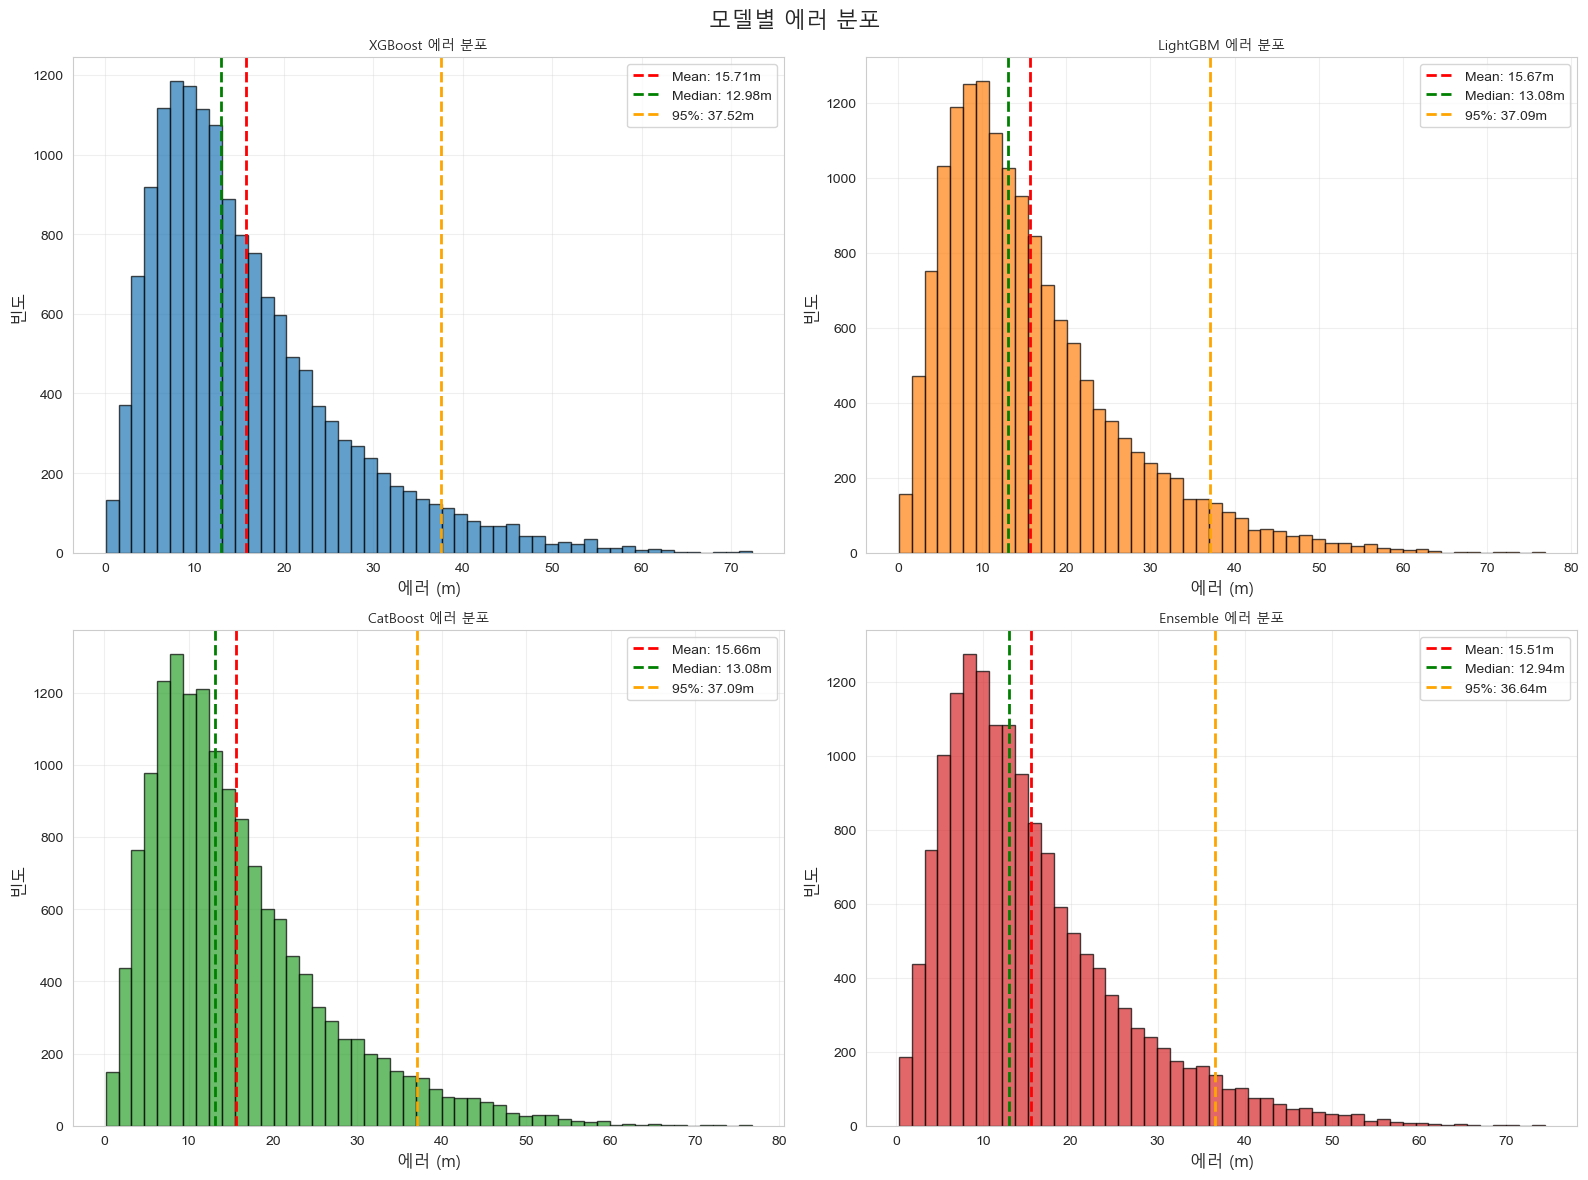

✅ 저장: error_distribution.png


In [33]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('모델별 에러 분포', fontsize=16, fontweight='bold', fontproperties=font_prop)

models = ['xgb', 'lgb', 'cat', 'ensemble']
titles = ['XGBoost', 'LightGBM', 'CatBoost', 'Ensemble']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, (model, title, color) in enumerate(zip(models, titles, colors)):
    ax = axes[i // 2, i % 2]
    
    error_col = f'error_{model}'
    
    # 히스토그램
    ax.hist(df[error_col], bins=50, color=color, alpha=0.7, edgecolor='black')
    
    # 통계선
    mean = df[error_col].mean()
    median = df[error_col].median()
    p95 = df[error_col].quantile(0.95)
    
    ax.axvline(mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean:.2f}m')
    ax.axvline(median, color='green', linestyle='--', linewidth=2, label=f'Median: {median:.2f}m')
    ax.axvline(p95, color='orange', linestyle='--', linewidth=2, label=f'95%: {p95:.2f}m')
    
    ax.set_title(f'{title} 에러 분포', fontsize=14, fontweight='bold', fontproperties=font_prop)
    ax.set_xlabel('에러 (m)', fontsize=12, fontproperties=font_prop)
    ax.set_ylabel('빈도', fontsize=12, fontproperties=font_prop)
    ax.legend(loc='upper right')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'error_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ 저장: error_distribution.png")

### 4.2 실제 vs 예측 산점도 (Ensemble)

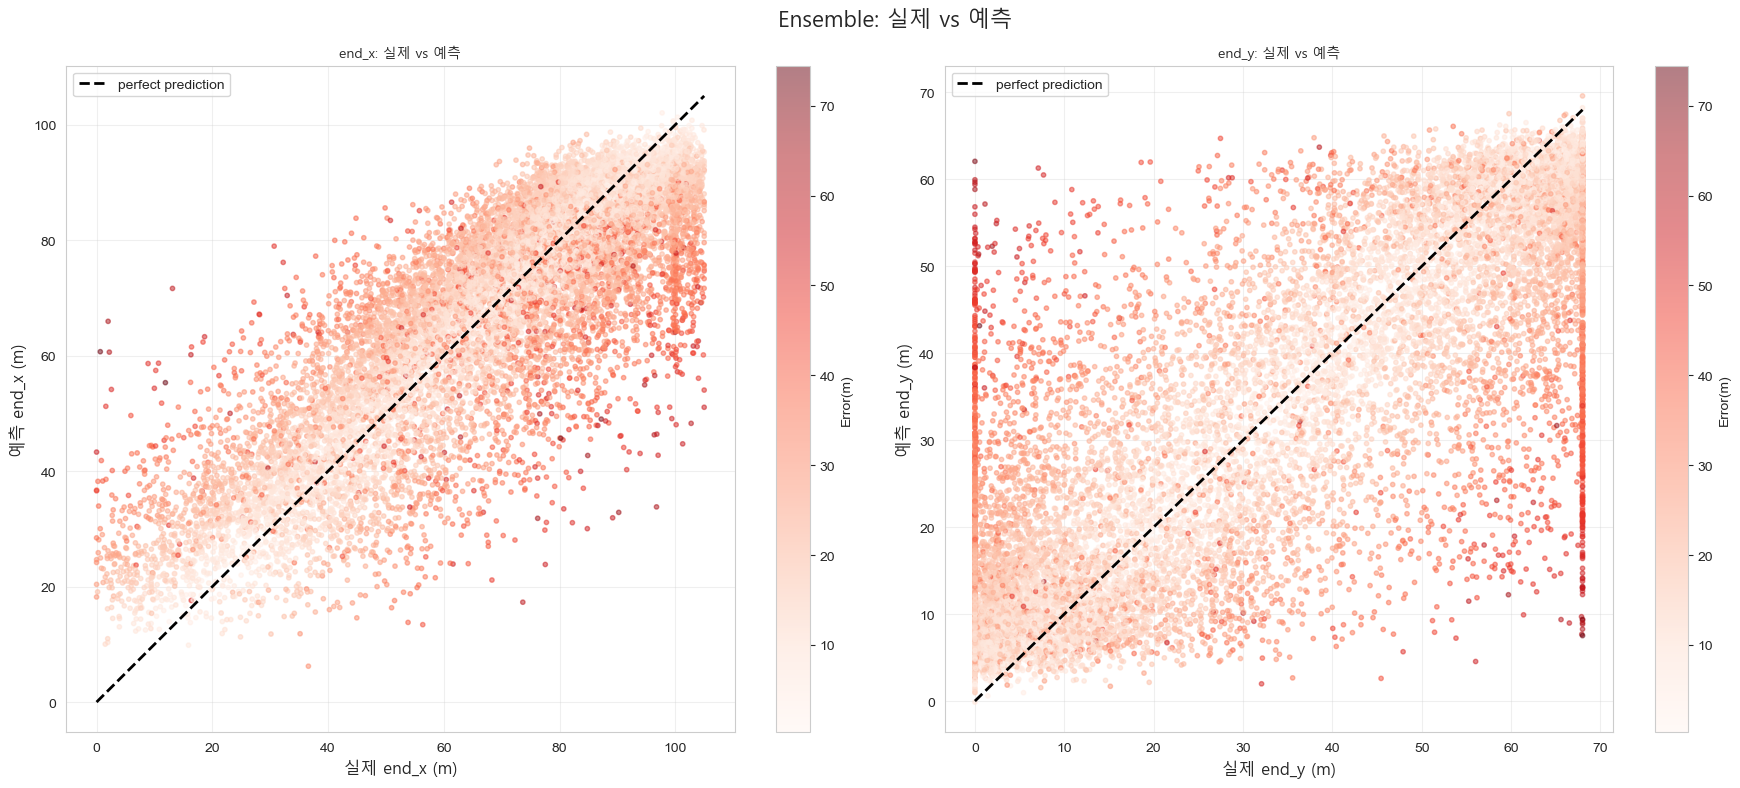

✅ 저장: actual_vs_predicted.png


In [34]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Ensemble: 실제 vs 예측', fontsize=16, fontweight='bold', fontproperties=font_prop)

# end_x
ax = axes[0]
scatter = ax.scatter(
    df['true_x'], df['ensemble_pred_x'], 
    c=df['error_ensemble'], cmap='Reds', alpha=0.5, s=10
)
ax.plot([0, 105], [0, 105], 'k--', linewidth=2, label='perfect prediction')
ax.set_xlabel('실제 end_x (m)', fontsize=12, fontproperties=font_prop)
ax.set_ylabel('예측 end_x (m)', fontsize=12, fontproperties=font_prop)
ax.set_title('end_x: 실제 vs 예측', fontsize=14, fontweight='bold', fontproperties=font_prop)
ax.legend()
ax.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Error(m)')

# end_y
ax = axes[1]
scatter = ax.scatter(
    df['true_y'], df['ensemble_pred_y'], 
    c=df['error_ensemble'], cmap='Reds', alpha=0.5, s=10
)
ax.plot([0, 68], [0, 68], 'k--', linewidth=2, label='perfect prediction')
ax.set_xlabel('실제 end_y (m)', fontsize=12,fontproperties=font_prop)
ax.set_ylabel('예측 end_y (m)', fontsize=12, fontproperties=font_prop)
ax.set_title('end_y: 실제 vs 예측', fontsize=14, fontweight='bold', fontproperties=font_prop)
ax.legend()
ax.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Error(m)')

plt.tight_layout()
plt.savefig(FIG_DIR / 'actual_vs_predicted.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ 저장: actual_vs_predicted.png")

### 4.3 에러 히트맵 (경기장 위)

In [35]:
# 경기장 그리기 함수
def draw_football_pitch(ax):
    """축구 경기장 그리기"""
    # 외곽선
    ax.add_patch(Rectangle((0, 0), 105, 68, fill=False, edgecolor='black', linewidth=2))
    
    # 중앙선
    ax.plot([52.5, 52.5], [0, 68], 'black', linewidth=2)
    
    # 페널티 박스 (왼쪽)
    ax.add_patch(Rectangle((0, 13.84), 16.5, 40.32, fill=False, edgecolor='black', linewidth=2))
    
    # 페널티 박스 (오른쪽)
    ax.add_patch(Rectangle((88.5, 13.84), 16.5, 40.32, fill=False, edgecolor='black', linewidth=2))
    
    # 골대
    ax.plot([0, 0], [30.34, 37.66], 'red', linewidth=4)
    ax.plot([105, 105], [30.34, 37.66], 'red', linewidth=4)
    
    ax.set_xlim(-2, 107)
    ax.set_ylim(-2, 70)
    ax.set_aspect('equal')
    ax.axis('off')

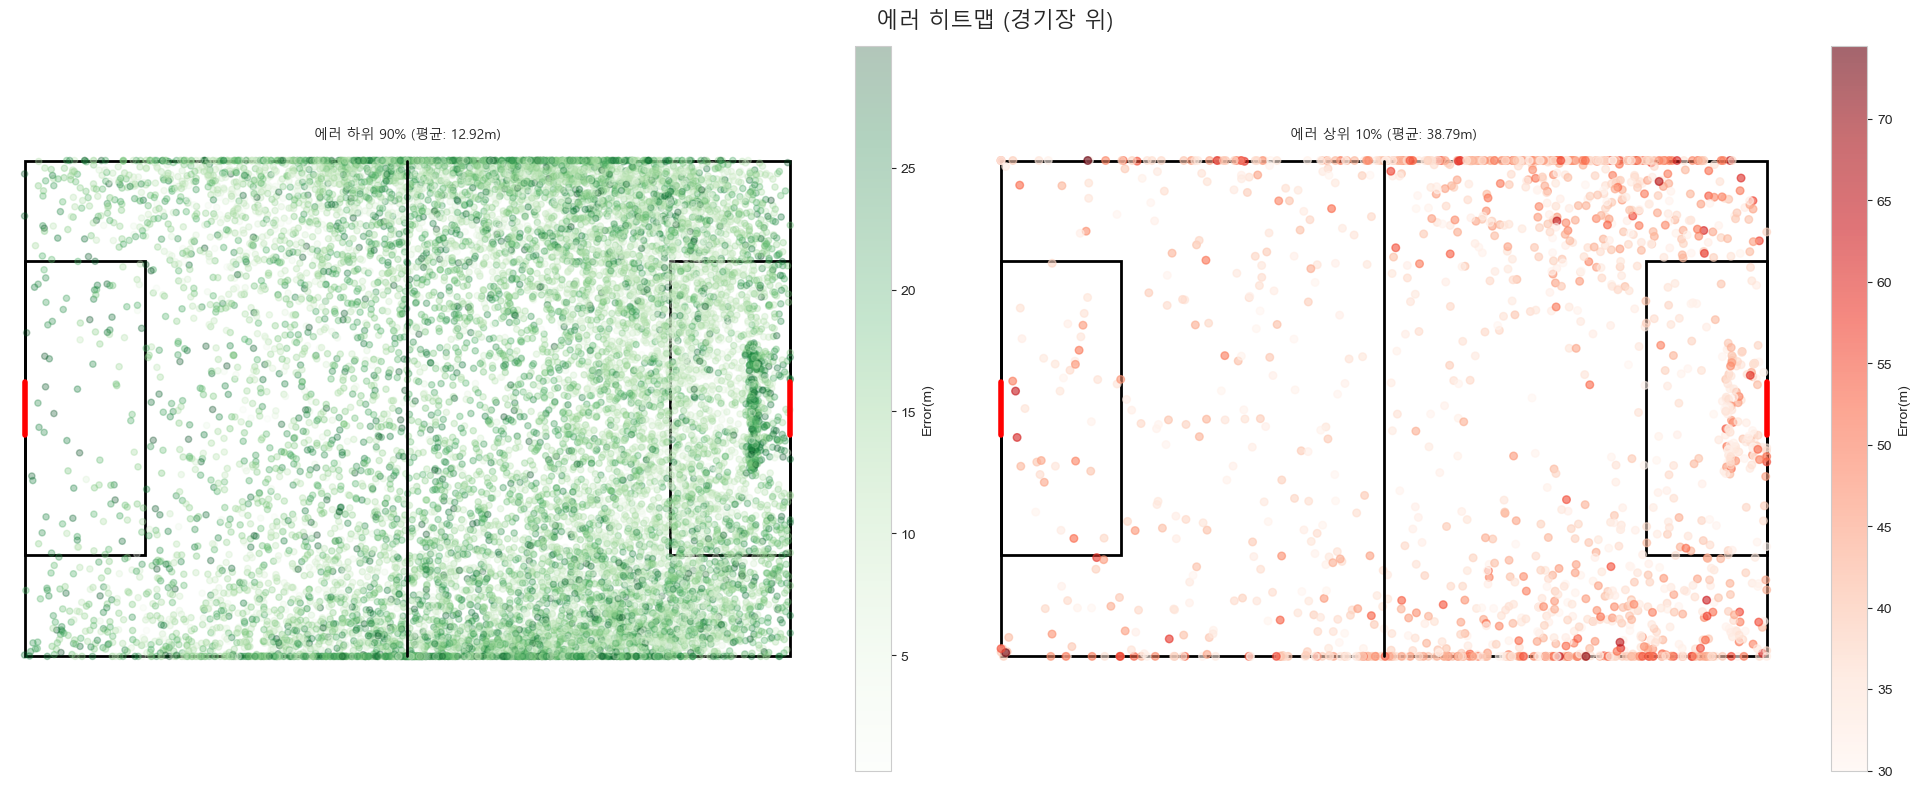


✅ 저장: error_heatmap.png
   에러 상위 10% 기준: 29.98m


In [36]:
# 에러 히트맵 (실제 좌표 기준)
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('에러 히트맵 (경기장 위)', fontsize=16, fontweight='bold', fontproperties=font_prop)

# 에러 상위 10%와 하위 90% 분리
error_threshold = df['error_ensemble'].quantile(0.9)
high_error = df[df['error_ensemble'] >= error_threshold]
low_error = df[df['error_ensemble'] < error_threshold]

# 왼쪽: 에러 작은 케이스
ax = axes[0]
draw_football_pitch(ax)
scatter = ax.scatter(
    low_error['true_x'], low_error['true_y'],
    c=low_error['error_ensemble'], cmap='Greens', alpha=0.3, s=20
)
ax.set_title(f'에러 하위 90% (평균: {low_error["error_ensemble"].mean():.2f}m)', 
             fontsize=14, fontweight='bold', fontproperties=font_prop)
plt.colorbar(scatter, ax=ax, label='Error(m)')

# 오른쪽: 에러 큰 케이스
ax = axes[1]
draw_football_pitch(ax)
scatter = ax.scatter(
    high_error['true_x'], high_error['true_y'],
    c=high_error['error_ensemble'], cmap='Reds', alpha=0.6, s=30
)
ax.set_title(f'에러 상위 10% (평균: {high_error["error_ensemble"].mean():.2f}m)', 
             fontsize=14, fontweight='bold', fontproperties=font_prop)
plt.colorbar(scatter, ax=ax, label='Error(m)')

plt.tight_layout()
plt.savefig(FIG_DIR / 'error_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ 저장: error_heatmap.png")
print(f"   에러 상위 10% 기준: {error_threshold:.2f}m")

## 5. 고오차 케이스 분석

### 5.1 에러 상위 10% 추출

In [37]:
print("\n" + "=" * 60)
print("고오차 케이스 분석")
print("=" * 60)

# 에러 상위 10%
error_threshold = df['error_ensemble'].quantile(0.9)
high_error = df[df['error_ensemble'] >= error_threshold].copy()
low_error = df[df['error_ensemble'] < error_threshold].copy()

print(f"\n✅ 에러 기준: {error_threshold:.2f}m")
print(f"   상위 10%: {len(high_error):,}개 (평균 에러: {high_error['error_ensemble'].mean():.2f}m)")
print(f"   하위 90%: {len(low_error):,}개 (평균 에러: {low_error['error_ensemble'].mean():.2f}m)")


고오차 케이스 분석

✅ 에러 기준: 29.98m
   상위 10%: 1,544개 (평균 에러: 38.79m)
   하위 90%: 13,891개 (평균 에러: 12.92m)


### 5.2 피처별 분포 비교

In [38]:
# 분석할 주요 피처
key_features = [
    # Phase 1
    'start_x', 'start_y', 'dist_to_target_goal', 'in_final_third',
    
    # Phase 2
    'prev_action_distance', 'time_since_prev',
    
    # Phase 3
    'pass_velocity', 'touchline_proximity', 'is_under_pressure',
    
    # Phase 4
    'player_avg_pass_distance', 'player_success_rate',
    'score_diff', 'match_period_normalized'
]

print("\n📊 피처별 평균값 비교 (상위 10% vs 하위 90%)")
print("=" * 80)

comparison = []

for feat in key_features:
    if feat not in df.columns:
        continue
        
    high_mean = high_error[feat].mean()
    low_mean = low_error[feat].mean()
    diff = high_mean - low_mean
    diff_pct = (diff / low_mean * 100) if low_mean != 0 else 0
    
    comparison.append({
        'feature': feat,
        'high_error_mean': high_mean,
        'low_error_mean': low_mean,
        'diff': diff,
        'diff_pct': diff_pct
    })

comparison_df = pd.DataFrame(comparison)
comparison_df = comparison_df.sort_values('diff_pct', key=abs, ascending=False)

# 출력
for _, row in comparison_df.head(15).iterrows():
    print(f"{row['feature']:30s} | "
          f"High: {row['high_error_mean']:8.2f} | "
          f"Low: {row['low_error_mean']:8.2f} | "
          f"Diff: {row['diff']:+8.2f} ({row['diff_pct']:+6.1f}%)")

print("\n💡 차이가 큰 피처일수록 고오차와 관련 있음!")


📊 피처별 평균값 비교 (상위 10% vs 하위 90%)
score_diff                     | High:    -0.06 | Low:    -0.01 | Diff:    -0.05 (+537.0%)
in_final_third                 | High:     0.07 | Low:     0.36 | Diff:    -0.28 ( -79.6%)
touchline_proximity            | High:    20.00 | Low:    14.27 | Diff:    +5.72 ( +40.1%)
is_under_pressure              | High:     0.23 | Low:     0.34 | Diff:    -0.11 ( -33.5%)
time_since_prev                | High:     4.31 | Low:     3.28 | Diff:    +1.03 ( +31.3%)
start_x                        | High:    40.49 | Low:    56.52 | Diff:   -16.03 ( -28.4%)
pass_velocity                  | High:     2.65 | Low:     3.56 | Diff:    -0.91 ( -25.5%)
player_avg_pass_distance       | High:    18.82 | Low:    16.13 | Diff:    +2.69 ( +16.7%)
dist_to_target_goal            | High:    55.14 | Low:    57.56 | Diff:    -2.42 (  -4.2%)
start_y                        | High:    32.89 | Low:    33.68 | Diff:    -0.80 (  -2.4%)
match_period_normalized        | High:     0.28 | Low:   

### 5.3 범주형 피처 분석

In [39]:
print("\n" + "=" * 60)
print("범주형 피처 분석")
print("=" * 60)

categorical_features = ['zone_combined', 'in_final_third', 'is_under_pressure']

for feat in categorical_features:
    if feat not in df.columns:
        continue
        
    print(f"\n📊 {feat}")
    print("-" * 60)
    
    # 고오차/저오차별 분포
    high_dist = high_error[feat].value_counts(normalize=True).sort_index()
    low_dist = low_error[feat].value_counts(normalize=True).sort_index()
    
    comparison = pd.DataFrame({
        'High Error (%)': high_dist * 100,
        'Low Error (%)': low_dist * 100
    }).fillna(0)
    
    comparison['Diff (%)'] = comparison['High Error (%)'] - comparison['Low Error (%)']
    
    print(comparison.round(1))


범주형 피처 분석

📊 zone_combined
------------------------------------------------------------
                  High Error (%)  Low Error (%)  Diff (%)
zone_combined                                            
attacking_center             2.4            9.3      -6.9
attacking_left               2.1           12.9     -10.8
attacking_right              2.7           13.3     -10.6
defensive_center            21.8            5.8      16.0
defensive_left               8.8            8.7       0.2
defensive_right              7.3            7.9      -0.7
midfield_center             21.1            8.8      12.3
midfield_left               18.3           17.1       1.2
midfield_right              15.5           16.1      -0.6

📊 in_final_third
------------------------------------------------------------
                High Error (%)  Low Error (%)  Diff (%)
in_final_third                                         
0                         92.7           64.4      28.3
1                         

### 5.4 시각화: 피처별 분포 비교

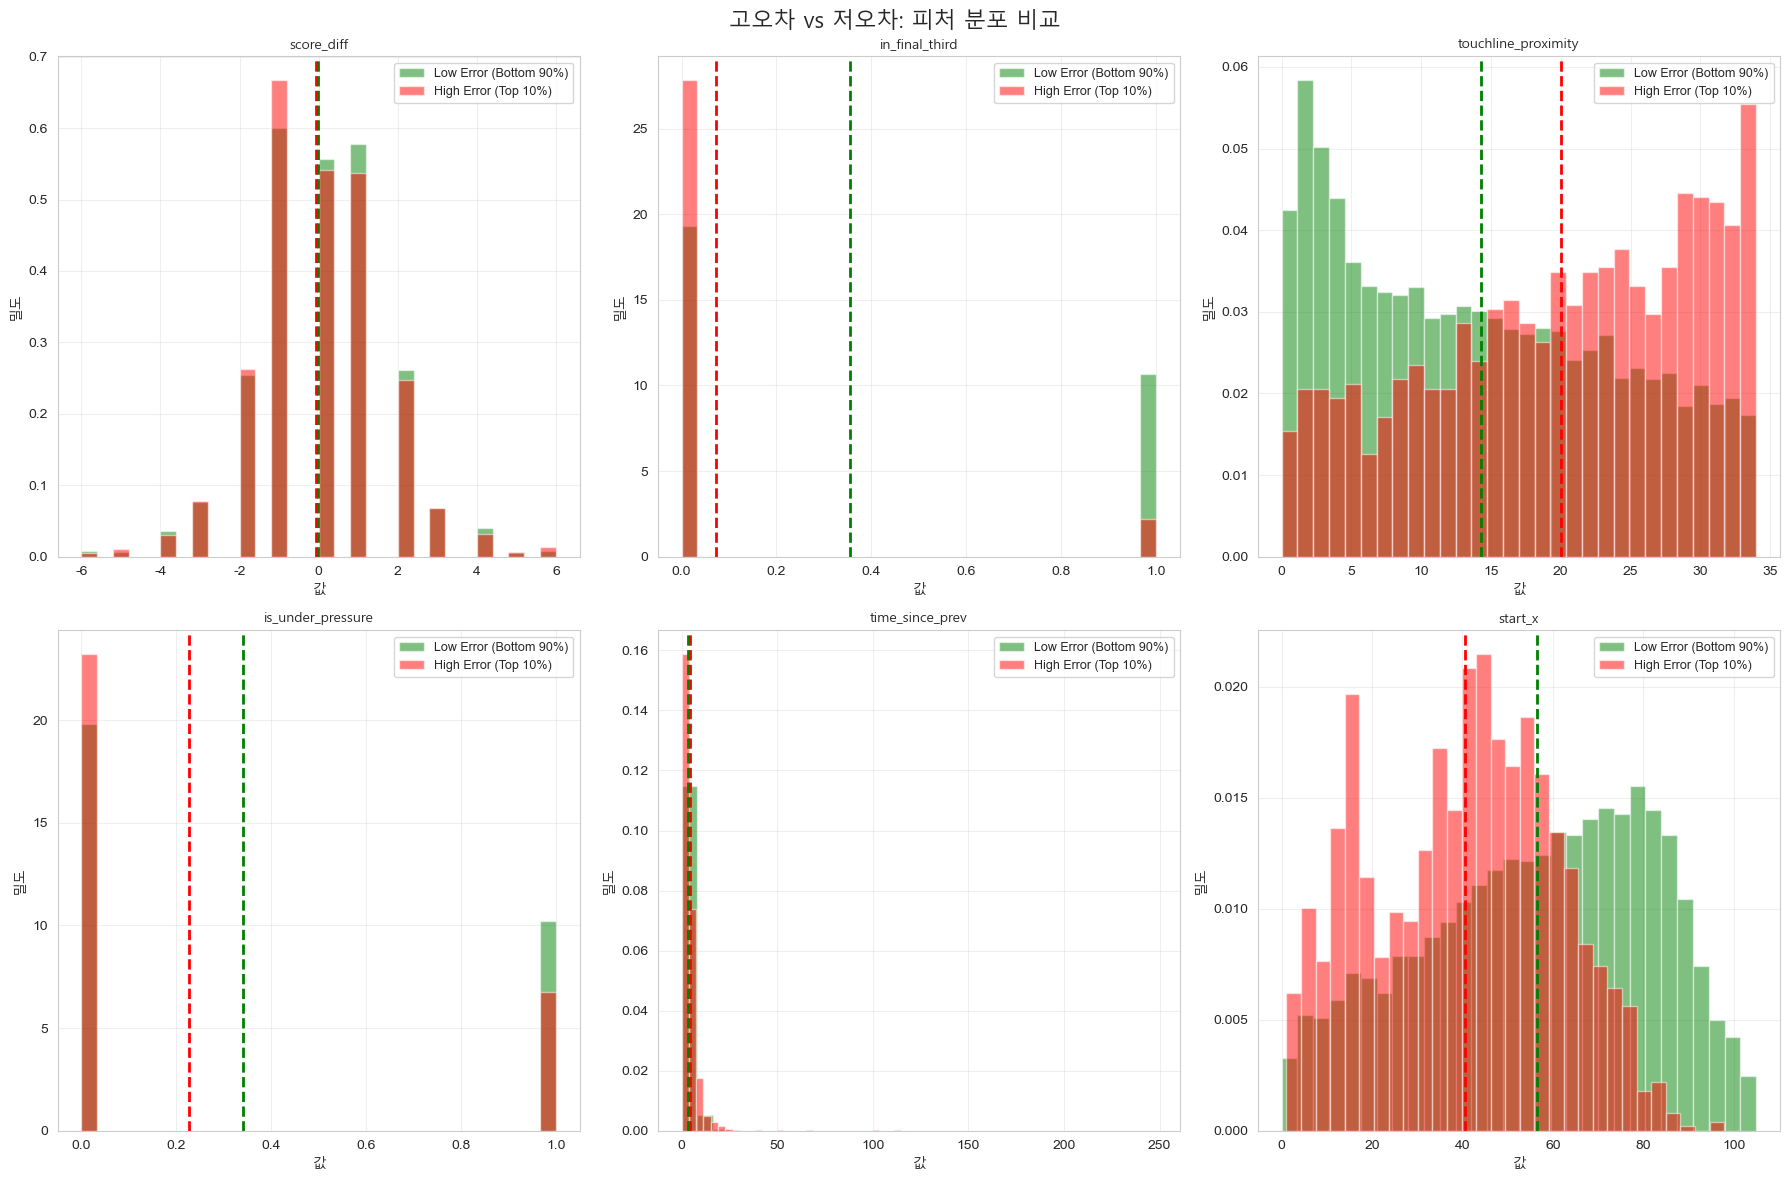

✅ 저장: feature_comparison_error.png


In [40]:
# 상위 6개 차이 나는 피처 시각화
top_features = comparison_df.head(6)['feature'].tolist()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('고오차 vs 저오차: 피처 분포 비교', fontsize=16, fontweight='bold', fontproperties=font_prop)

for i, feat in enumerate(top_features):
    ax = axes[i // 3, i % 3]
    
    # 히스토그램
    ax.hist(low_error[feat], bins=30, alpha=0.5, label='Low Error (Bottom 90%)', 
            color='green', density=True)
    ax.hist(high_error[feat], bins=30, alpha=0.5, label='High Error (Top 10%)', 
            color='red', density=True)
    
    # 평균선
    ax.axvline(low_error[feat].mean(), color='green', linestyle='--', linewidth=2)
    ax.axvline(high_error[feat].mean(), color='red', linestyle='--', linewidth=2)

    ax.set_title(feat, fontsize=12, fontweight='bold', fontproperties=font_prop)
    ax.set_xlabel('값', fontsize=10, fontproperties=font_prop)
    ax.set_ylabel('밀도', fontsize=10, fontproperties=font_prop)
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'feature_comparison_error.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ 저장: feature_comparison_error.png")

## 6. 인사이트 도출

In [41]:
print("\n" + "=" * 60)
print("주요 인사이트")
print("=" * 60)

# 인사이트 1: 가장 차이 나는 피처
top3 = comparison_df.head(3)
print("\n🔍 인사이트 1: 고오차와 가장 관련 있는 피처")
print("-" * 60)
for _, row in top3.iterrows():
    print(f"  • {row['feature']:30s}: {row['diff_pct']:+6.1f}% 차이")

# 인사이트 2: 에러가 큰 구역
print("\n🔍 인사이트 2: 에러가 큰 구역")
print("-" * 60)
if 'zone_combined' in df.columns:
    zone_error = df.groupby('zone_combined')['error_ensemble'].agg(['mean', 'count'])
    zone_error = zone_error.sort_values('mean', ascending=False)
    print(zone_error.head())

# 인사이트 3: 시간대별 에러
print("\n🔍 인사이트 3: 경기 진행률별 에러")
print("-" * 60)
if 'match_period_normalized' in df.columns:
    df['period_bin'] = pd.cut(df['match_period_normalized'], bins=5, 
                               labels=['0-20%', '20-40%', '40-60%', '60-80%', '80-100%'])
    period_error = df.groupby('period_bin')['error_ensemble'].agg(['mean', 'count'])
    print(period_error)

print("\n" + "=" * 60)


주요 인사이트

🔍 인사이트 1: 고오차와 가장 관련 있는 피처
------------------------------------------------------------
  • score_diff                    : +537.0% 차이
  • in_final_third                :  -79.6% 차이
  • touchline_proximity           :  +40.1% 차이

🔍 인사이트 2: 에러가 큰 구역
------------------------------------------------------------
                       mean  count
zone_combined                     
defensive_center  23.982598   1143
midfield_center   21.379516   1554
defensive_left    16.339569   1338
midfield_left     16.273473   2652
midfield_right    15.542658   2481

🔍 인사이트 3: 경기 진행률별 에러
------------------------------------------------------------
                 mean  count
period_bin                  
0-20%       15.765348   3953
20-40%      15.536297   3484
40-60%      15.163757   3390
60-80%      15.351330   3590
80-100%     16.131352   1018



C:\Users\user\AppData\Local\Temp\ipykernel_20556\225128727.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  period_error = df.groupby('period_bin')['error_ensemble'].agg(['mean', 'count'])


## 7. 개선 방향 제안

In [42]:
print("\n" + "=" * 60)
print("Phase 6 개선 방향 제안")
print("=" * 60)

print("""
🎯 제안 1: 고오차 구역 특화 피처
   - 에러가 큰 구역(zone)별 가중치 피처
   - 구역별 선수 스타일 차이
   - 구역별 팀 전술 패턴

🎯 제안 2: 상황별 모델
   - 페널티 박스 근처 vs 중원 구분 모델
   - 측면 공격 vs 중앙 공격 구분 모델
   - 경기 시간대별 모델

🎯 제안 3: 피처 상호작용
   - start_x * in_final_third
   - player_avg_pass_distance * touchline_proximity
   - score_diff * match_period_normalized

🎯 제안 4: 이상치 처리
   - 극단적 패스 거리 케이스 별도 처리
   - 압박 상황 강화 피처
   - 경기 흐름 변화 감지 피처
""")

print("=" * 60)


Phase 6 개선 방향 제안

🎯 제안 1: 고오차 구역 특화 피처
   - 에러가 큰 구역(zone)별 가중치 피처
   - 구역별 선수 스타일 차이
   - 구역별 팀 전술 패턴

🎯 제안 2: 상황별 모델
   - 페널티 박스 근처 vs 중원 구분 모델
   - 측면 공격 vs 중앙 공격 구분 모델
   - 경기 시간대별 모델

🎯 제안 3: 피처 상호작용
   - start_x * in_final_third
   - player_avg_pass_distance * touchline_proximity
   - score_diff * match_period_normalized

🎯 제안 4: 이상치 처리
   - 극단적 패스 거리 케이스 별도 처리
   - 압박 상황 강화 피처
   - 경기 흐름 변화 감지 피처



## 8. 고오차 샘플 상세 분석

In [43]:
print("\n" + "=" * 60)
print("고오차 케이스 샘플 (Top 10)")
print("=" * 60)

# 에러 상위 10개
top10_error = df.nlargest(10, 'error_ensemble')

display_cols = [
    'game_episode', 'error_ensemble',
    'true_x', 'true_y', 'ensemble_pred_x', 'ensemble_pred_y',
    'start_x', 'start_y', 'dist_to_target_goal',
    'zone_combined', 'in_final_third',
    'player_avg_pass_distance', 'score_diff'
]

# 존재하는 컬럼만 선택
display_cols = [col for col in display_cols if col in top10_error.columns]

print("\n📋 에러 상위 10개 케이스:")
print(top10_error[display_cols].to_string(index=False))

print("\n💡 공통점을 찾아보세요!")


고오차 케이스 샘플 (Top 10)

📋 에러 상위 10개 케이스:
game_episode  error_ensemble    true_x    true_y  ensemble_pred_x  ensemble_pred_y   start_x   start_y  dist_to_target_goal    zone_combined  in_final_third  player_avg_pass_distance  score_diff
   126458_28       74.459526 11.890620 68.000000        55.331222         7.525749 16.854810  4.780944            33.731852   defensive_left               0                 19.212999          -1
    126444_7       73.660044  0.641445  0.508001        60.696233        43.160369 42.208635 40.207856            42.662704  midfield_center               0                 15.454008          -1
   126468_22       71.014390 80.212335  0.000000        45.716393        62.073131 34.283445 65.665472            46.669655  defensive_right               0                 17.805128           0
   126414_41       69.950511 87.210690 68.000000        49.018751         9.395822 43.728510  9.114516            66.132313    midfield_left               0                 16.94665

## 9. 구역별 에러 분석


구역별 상세 에러 분석

📊 구역별 에러 통계:
                  Error Mean  Error Std  Count  Avg X  Avg Y
zone_combined                                               
defensive_center       23.98      12.35   1143  47.21  33.87
midfield_center        21.38      10.73   1554  70.01  34.15
defensive_left         16.34      10.67   1338  39.13   9.81
midfield_left          16.27      10.38   2652  69.41  13.13
midfield_right         15.54      10.37   2481  67.52  55.21
defensive_right        15.19      10.52   1216  35.90  58.82
attacking_center       11.80       7.13   1325  88.50  33.63
attacking_left         11.03       6.72   1831  88.36  13.29
attacking_right        11.01       7.03   1895  88.20  53.71


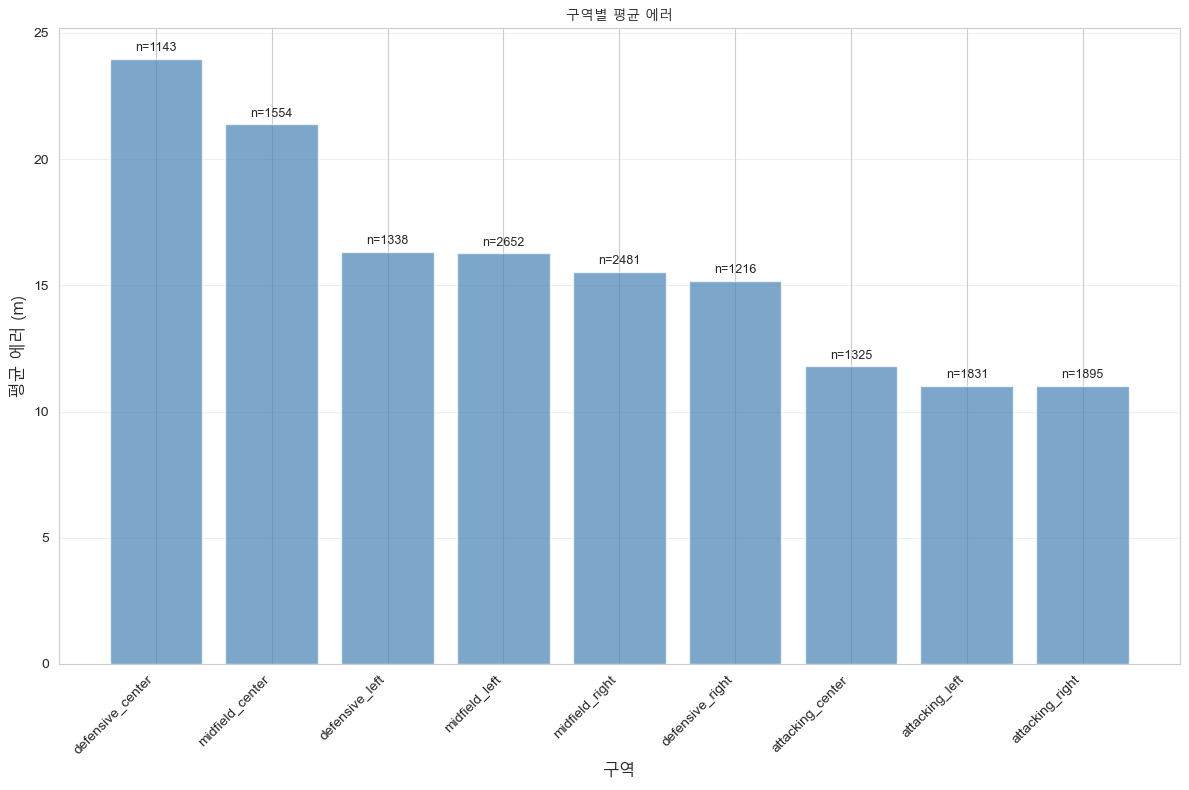


✅ 저장: zone_error_analysis.png


In [44]:
if 'zone_combined' in df.columns:
    print("\n" + "=" * 60)
    print("구역별 상세 에러 분석")
    print("=" * 60)
    
    zone_analysis = df.groupby('zone_combined').agg({
        'error_ensemble': ['mean', 'std', 'count'],
        'true_x': 'mean',
        'true_y': 'mean'
    }).round(2)
    
    zone_analysis.columns = ['Error Mean', 'Error Std', 'Count', 'Avg X', 'Avg Y']
    zone_analysis = zone_analysis.sort_values('Error Mean', ascending=False)
    
    print("\n📊 구역별 에러 통계:")
    print(zone_analysis)
    
    # 시각화
    fig, ax = plt.subplots(figsize=(12, 8))
    
    zones = zone_analysis.index
    errors = zone_analysis['Error Mean']
    counts = zone_analysis['Count']
    
    bars = ax.bar(range(len(zones)), errors, color='steelblue', alpha=0.7)
    
    # 샘플 수에 따라 색상 조정
    for i, (bar, count) in enumerate(zip(bars, counts)):
        if count < 100:
            bar.set_color('orange')
            bar.set_alpha(0.5)
    
    ax.set_xticks(range(len(zones)))
    ax.set_xticklabels(zones, rotation=45, ha='right')
    ax.set_xlabel('구역', fontsize=12, fontproperties=font_prop)
    ax.set_ylabel('평균 에러 (m)', fontsize=12, fontproperties=font_prop)
    ax.set_title('구역별 평균 에러', fontsize=14, fontweight='bold', fontproperties=font_prop)
    ax.grid(alpha=0.3, axis='y')
    
    # 샘플 수 표시
    for i, (error, count) in enumerate(zip(errors, counts)):
        ax.text(i, error + 0.3, f'n={count}', ha='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(FIG_DIR / 'zone_error_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✅ 저장: zone_error_analysis.png")

## 10. 요약 및 다음 단계

In [45]:
print("\n" + "=" * 60)
print("📊 에러 분석 요약")
print("=" * 60)

print(f"""
✅ 분석 완료 항목:
   1. 모델별 에러 분포 분석
   2. 고오차 케이스 (상위 10%) 추출 및 분석
   3. 피처별 고오차/저오차 비교
   4. 구역별 에러 패턴 파악
   5. 경기 상황별 에러 분석

📈 주요 발견:
   • 전체 평균 에러: {df['error_ensemble'].mean():.2f}m
   • 에러 중앙값: {df['error_ensemble'].median():.2f}m
   • 에러 90% 분위: {df['error_ensemble'].quantile(0.9):.2f}m
   • 상위 10% 평균: {high_error['error_ensemble'].mean():.2f}m

🎯 다음 단계 (Phase 6):
   1. 발견된 인사이트 기반 피처 개발
   2. 고오차 구역/상황 타겟팅 피처
   3. 피처 상호작용 추가
   4. 재학습 및 성능 검증

🎊 예상 개선:
   • CV: 13.35m → 13.0-13.2m (-0.1~0.3m)
   • LB: 16.53m → 16.2-16.4m (-0.1~0.3m)
""")

print("=" * 60)
print("\n✅ 에러 분석 완료!")
print("다음: Phase 6 피처 개발 진행")


📊 에러 분석 요약

✅ 분석 완료 항목:
   1. 모델별 에러 분포 분석
   2. 고오차 케이스 (상위 10%) 추출 및 분석
   3. 피처별 고오차/저오차 비교
   4. 구역별 에러 패턴 파악
   5. 경기 상황별 에러 분석

📈 주요 발견:
   • 전체 평균 에러: 15.51m
   • 에러 중앙값: 12.94m
   • 에러 90% 분위: 29.98m
   • 상위 10% 평균: 38.79m

🎯 다음 단계 (Phase 6):
   1. 발견된 인사이트 기반 피처 개발
   2. 고오차 구역/상황 타겟팅 피처
   3. 피처 상호작용 추가
   4. 재학습 및 성능 검증

🎊 예상 개선:
   • CV: 13.35m → 13.0-13.2m (-0.1~0.3m)
   • LB: 16.53m → 16.2-16.4m (-0.1~0.3m)


✅ 에러 분석 완료!
다음: Phase 6 피처 개발 진행


---

## 💡 사용 방법

1. **전체 실행**: 셀을 순서대로 실행
2. **시각화 확인**: `reports/figures/` 폴더에 저장된 이미지 확인
3. **인사이트 검토**: Section 6의 인사이트를 바탕으로 Phase 6 계획
4. **고오차 케이스 분석**: Section 8의 Top 10 케이스 상세 검토

---

**생성 파일:**
- `error_distribution.png`: 모델별 에러 분포
- `actual_vs_predicted.png`: 실제 vs 예측 산점도
- `error_heatmap.png`: 경기장 위 에러 히트맵
- `feature_comparison_error.png`: 피처별 분포 비교
- `zone_error_analysis.png`: 구역별 에러 분석